##Importing Libraries and Data

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from itertools import product

from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')
import datetime

In [ ]:
df = pd.read_csv('energydata_complete.csv')

Changing the data to include hourly increments

In [ ]:
df = df[::6]

Creating date time object

In [ ]:
date_time = pd.to_datetime(df.pop('date'), format = '%Y.%m.%d %H:%M:%S')

## Exploratory Data Analysis

Plotting initial trends of columns

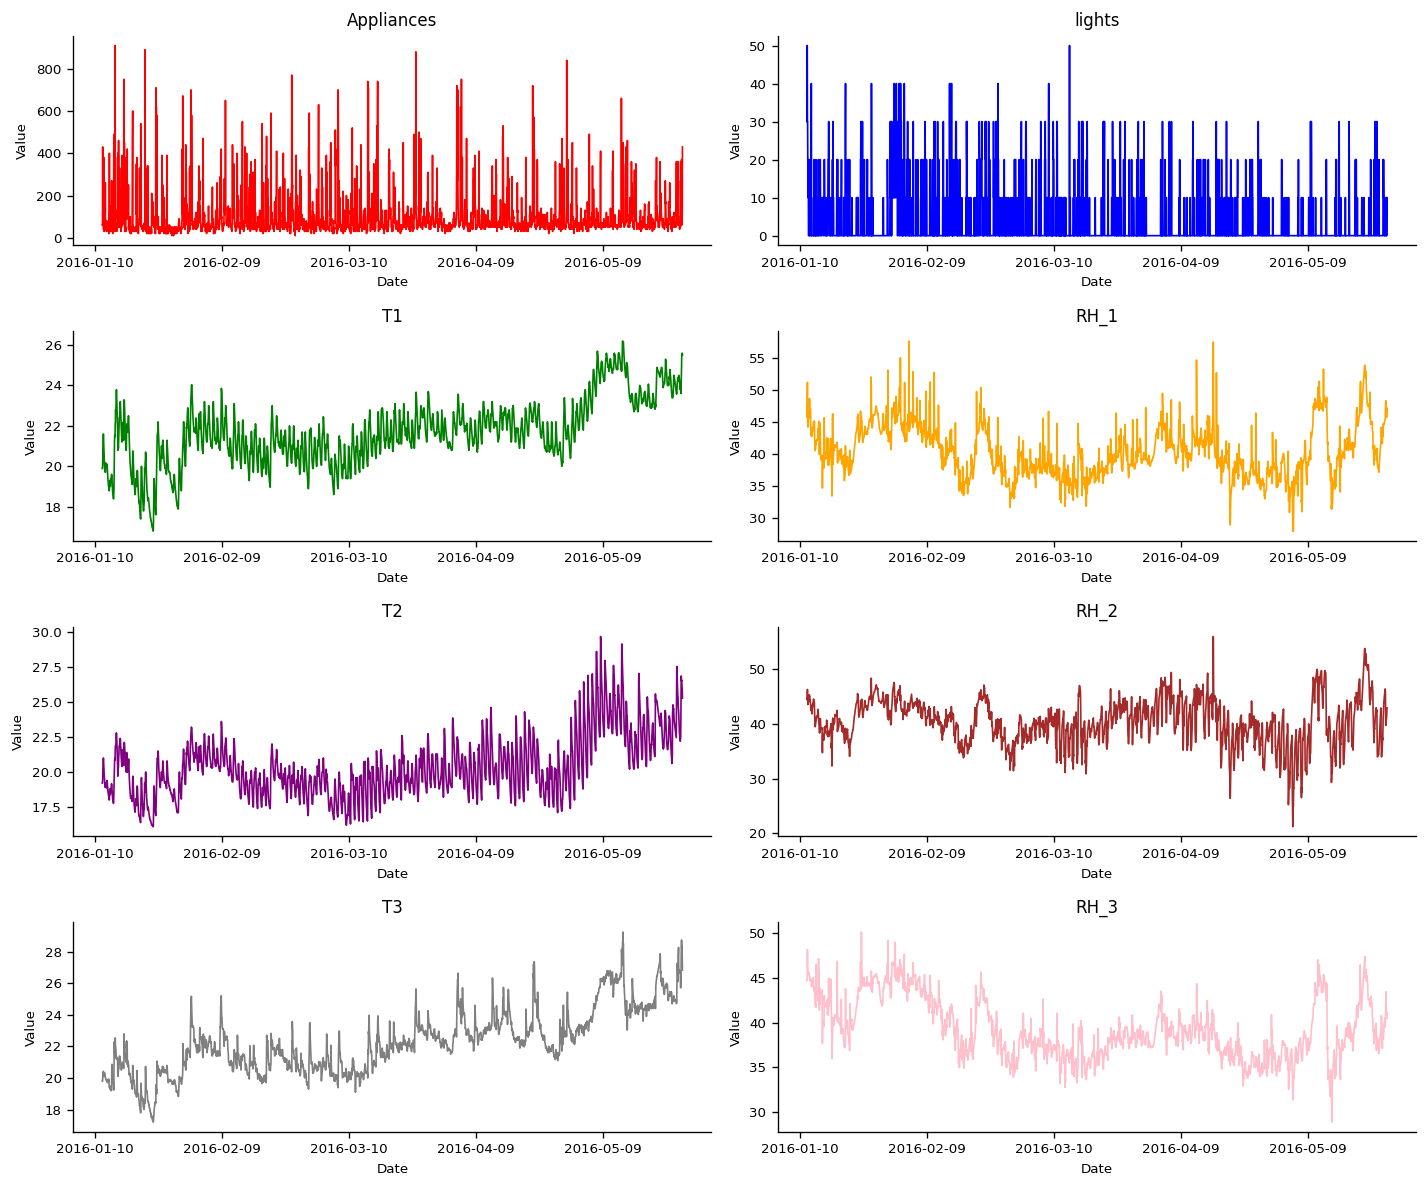

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10), dpi=120)

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'gray', 'pink']

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    data.index = date_time
    ax.plot(data, color=colors[i % len(colors)], linewidth=1)

    ax.set_title(df.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['top'].set_alpha(0)
    ax.spines['right'].set_alpha(0)
    ax.tick_params(labelsize=8)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.set_xlabel('Date', fontsize=8)
    ax.set_ylabel('Value', fontsize=8)

plt.tight_layout()

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
lights,3290.0,3.802432,7.954943,0.000000,0.000000,0.000000,0.000000,50.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333



Dropping Irrelevant Columns

In [8]:
drop_cols = ['lights', 'rv1', 'rv2']
df = df.drop(drop_cols, axis=1)

In [9]:
df.shape

(3290, 25)

## Feature Engineering

Creating a POSIX timestamp

In [10]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Checking for Monthly and/or Daily Seasonality

Text(0.5, 0, 'Frequency')

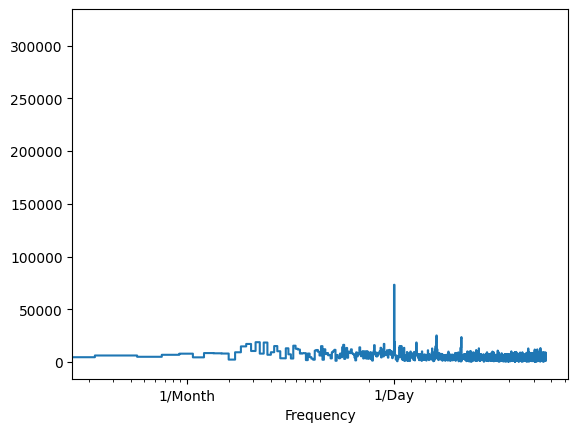

In [11]:
fft = tf.signal.rfft(df['Appliances'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['Appliances'])
hours_per_month = 24 * 30.4167
months_per_dataset = n_sample_h / hours_per_month

f_per_month = f_per_dataset / months_per_dataset

plt.step(f_per_month, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 30.4167], labels=['1/Month', '1/Day'])
plt.xlabel('Frequency')

Creating two new time features based on daily seasonality

In [12]:
day = 24 * 60 * 60

df['Day sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['Day cin'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [13]:
df.shape

(3290, 27)

Splitting the Data

In [14]:
column_index = {name: i for i, name in enumerate(df.columns)}

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.3, shuffle=False)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

num_features = df.shape[1]
print(num_features)

27


Standardizing the data through feature scaling

In [28]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

In [29]:
train_data.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Day sin,Day cin
0,-0.361874,-0.949396,2.019829,-0.257961,1.199843,-1.110214,1.577297,-0.654620,1.438200,-1.276236,...,-1.099772,0.909371,0.211968,-2.689356,0.754481,0.983558,1.709408,0.688470,-1.366409,-0.366213
6,-0.361874,-0.949396,1.506004,-0.257961,1.110765,-1.110214,1.631663,-0.729513,1.490822,-1.328162,...,-1.123256,0.848321,0.043789,-2.614703,0.754481,0.238816,0.078323,0.526112,-1.414592,-0.000307
12,3.075384,-0.753485,2.133076,-0.011160,1.080048,-1.042013,1.631663,-0.654620,1.625909,-1.328162,...,-1.149089,0.848321,0.067815,-2.564934,0.674377,0.611187,0.078323,0.499052,-1.366409,0.365599
18,-0.176076,-0.144282,3.029695,0.415134,1.672879,-0.830589,2.684856,-0.679584,2.159975,-1.250273,...,-1.200755,0.825427,0.067815,-2.477839,0.434066,0.611187,0.078323,0.363754,-1.225144,0.706570
24,0.102620,0.051629,1.588366,0.567702,1.190628,-0.769207,2.122016,-0.389089,2.057089,-0.814091,...,-1.200755,0.766073,0.067815,-2.452955,0.353962,0.611187,0.078323,0.309635,-1.000423,0.999367


## Data Windowing

In [106]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_data=train_data, val_data=val_data, test_data=test_data,
                 label_columns=None):

        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        self.label_columns = label_columns

        # Defining column indices
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_data.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.out_steps = self.label_width

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Appliances', max_subplots=3):
        inputs, labels = self.example

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')

    def plot_predicted_24_hours(self, model=None, plot_col='Appliances'):
      inputs, labels = self.example

      plt.figure(figsize=(12, 4))
      plot_col_index = self.column_indices[plot_col]

      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[0, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
          label_col_index = plot_col_index

      if label_col_index is None:
          return

      if model is not None:
          predictions = model.predict(inputs)
          predicted_col_index = self.label_columns_indices[plot_col]
          plt.plot(self.label_indices + self.out_steps, predictions[0, :, predicted_col_index],
                  marker='X', label='Predictions', c='#ff7f0e', markersize=8)

      plt.scatter(self.label_indices, labels[0, :, label_col_index],
                  edgecolors='k', label='True Values', c='#2ca02c', s=64)

      plt.legend()
      plt.xlabel('Time (h)')


    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_window)
        return ds



    @property
    def train(self):
        return self.make_dataset(self.train_data)

    @property
    def val(self):
        return self.make_dataset(self.val_data)

    @property
    def test(self):
        return self.make_dataset(self.test_data)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [107]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience = 3):
  early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode = 'min')

  model.compile(loss=MeanSquaredError(), optimizer = Adam(), metrics = [MeanAbsoluteError()])

  history = model.fit(window.train, epochs = MAX_EPOCHS, validation_data = window.val, callbacks=[early_stopping])

  return history

## Deep Learning Models

Creating Window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['Appliances']

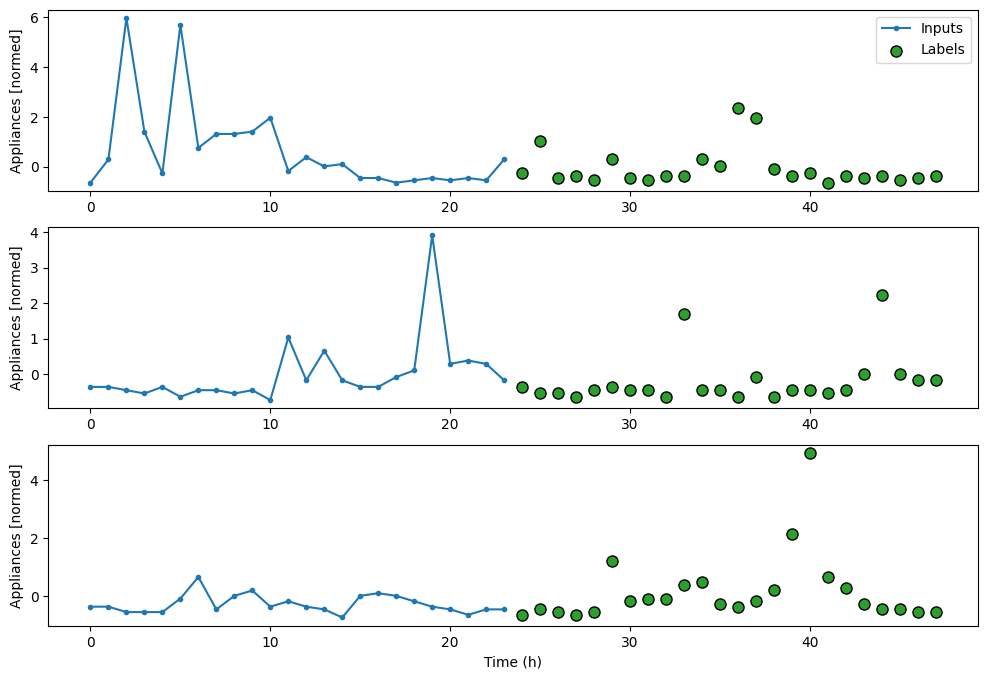

In [108]:
OUT_STEPS = 24

predict_window = WindowGenerator(
    input_width = 24,
    label_width = 24,
    shift = OUT_STEPS,
    label_columns = ['Appliances']
)

predict_window.plot()
predict_window

Create Baseline Model to compare model's metrics

In [33]:
class RepeatBaseline(Model):
  def call(self, inputs):
    return inputs

In [34]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Repeat'] = repeat_baseline.evaluate(predict_window.val)
performance['Repeat'] = repeat_baseline.evaluate(predict_window.test, verbose = 0)

14/14 [==============================] - 0s 2ms/step - loss: 1.9636 - mean_absolute_error: 1.0494


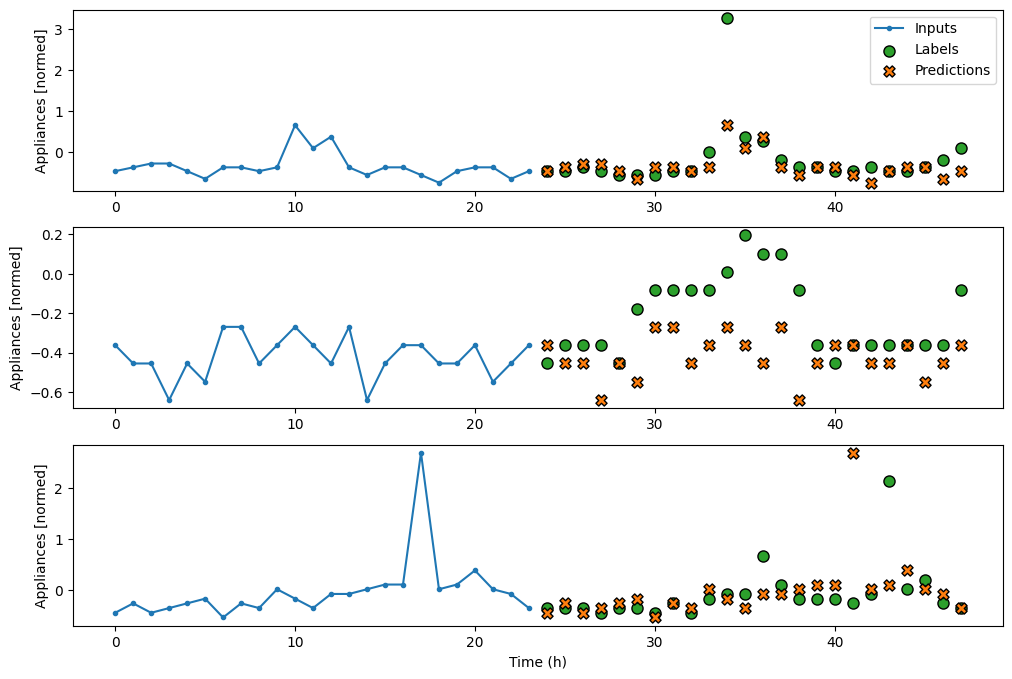

In [35]:
predict_window.plot(repeat_baseline)

Linear Model

In [102]:
linear_model = Sequential([
    #Take last time step
    Lambda(lambda x: x[:, -1:, :]),
    Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(linear_model, predict_window)

val_performance['Linear'] = linear_model.evaluate(predict_window.val)
performance['Linear'] = linear_model.evaluate(predict_window.test, verbose = 0)

Epoch 1/50
71/71 [==============================] - 1s 6ms/step - loss: 0.9653 - mean_absolute_error: 0.5701 - val_loss: 0.6110 - val_mean_absolute_error: 0.4506
Epoch 2/50
71/71 [==============================] - 0s 5ms/step - loss: 0.9214 - mean_absolute_error: 0.5451 - val_loss: 0.6032 - val_mean_absolute_error: 0.4366
Epoch 3/50
71/71 [==============================] - 1s 8ms/step - loss: 0.9014 - mean_absolute_error: 0.5334 - val_loss: 0.6015 - val_mean_absolute_error: 0.4383
Epoch 4/50
71/71 [==============================] - 1s 7ms/step - loss: 0.8906 - mean_absolute_error: 0.5270 - val_loss: 0.6004 - val_mean_absolute_error: 0.4343
Epoch 5/50
71/71 [==============================] - 0s 6ms/step - loss: 0.8836 - mean_absolute_error: 0.5232 - val_loss: 0.5989 - val_mean_absolute_error: 0.4311
Epoch 6/50
71/71 [==============================] - 0s 6ms/step - loss: 0.8795 - mean_absolute_error: 0.5211 - val_loss: 0.5972 - val_mean_absolute_error: 0.4292
Epoch 7/50
71/71 [==========

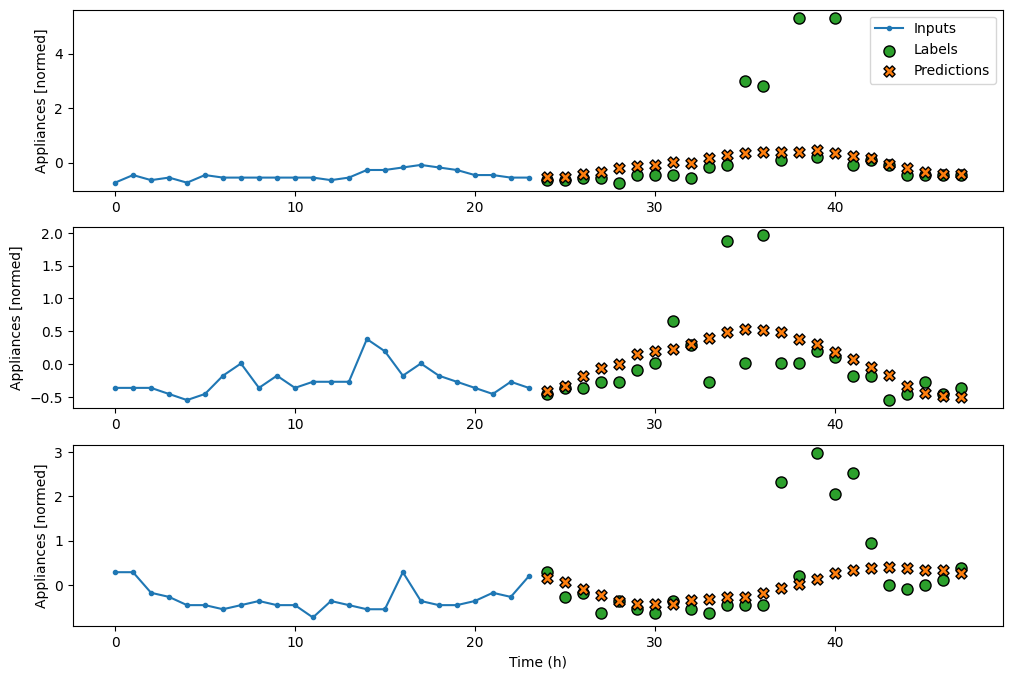

In [103]:
predict_window.plot(linear_model)

Dense Model

In [38]:
dense_model = Sequential([
    Lambda(lambda x: x[:, -1:, :]),
    Dense(512, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(dense_model, predict_window)

val_performance['Dense'] = dense_model.evaluate(predict_window.val)
performance['Dense'] = dense_model.evaluate(predict_window.test, verbose = 0)

Epoch 1/50
71/71 [==============================] - 2s 11ms/step - loss: 0.9101 - mean_absolute_error: 0.5410 - val_loss: 0.5771 - val_mean_absolute_error: 0.3897
Epoch 2/50
71/71 [==============================] - 1s 9ms/step - loss: 0.8342 - mean_absolute_error: 0.5171 - val_loss: 0.5925 - val_mean_absolute_error: 0.3614
Epoch 3/50
71/71 [==============================] - 1s 8ms/step - loss: 0.7895 - mean_absolute_error: 0.5084 - val_loss: 0.5923 - val_mean_absolute_error: 0.3769
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.5959 - mean_absolute_error: 0.3762


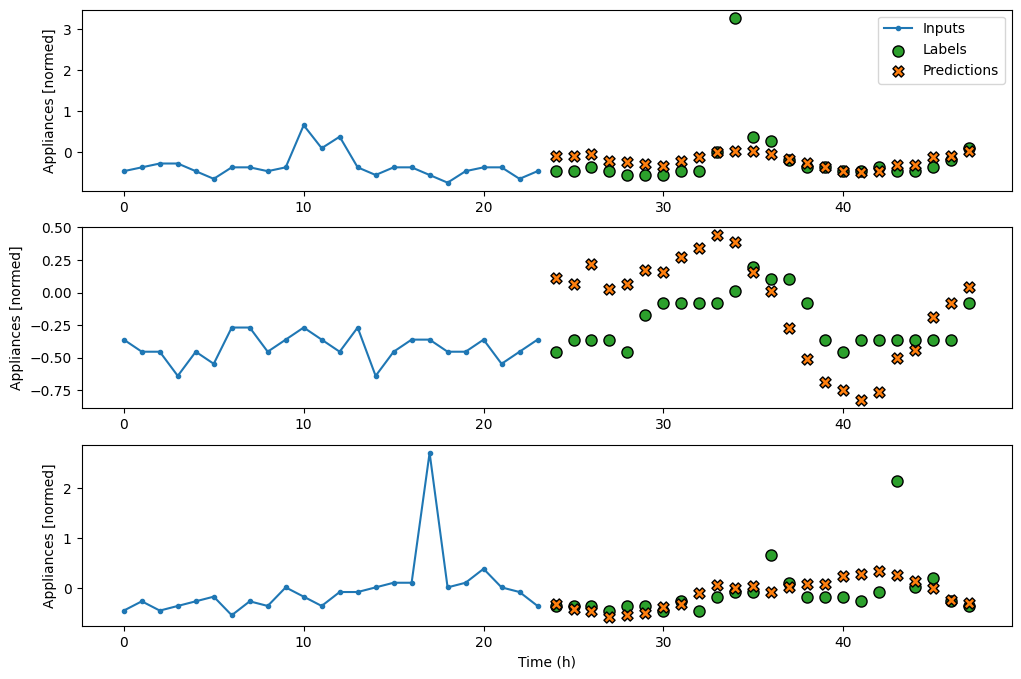

In [39]:
predict_window.plot(dense_model)

Convolution Model

In [40]:
CONV_WIDTH = 3

cnn_model = Sequential([
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    Conv1D(256, activation='relu', kernel_size = CONV_WIDTH),
    Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(cnn_model, predict_window)

val_performance['CNN'] = cnn_model.evaluate(predict_window.val)
performance['CNN'] = cnn_model.evaluate(predict_window.test, verbose = 0)

Epoch 1/50
71/71 [==============================] - 1s 8ms/step - loss: 0.9133 - mean_absolute_error: 0.5403 - val_loss: 0.5815 - val_mean_absolute_error: 0.4172
Epoch 2/50
71/71 [==============================] - 0s 6ms/step - loss: 0.8560 - mean_absolute_error: 0.5217 - val_loss: 0.5672 - val_mean_absolute_error: 0.3977
Epoch 3/50
71/71 [==============================] - 0s 5ms/step - loss: 0.8313 - mean_absolute_error: 0.5180 - val_loss: 0.5721 - val_mean_absolute_error: 0.3960
Epoch 4/50
71/71 [==============================] - 1s 8ms/step - loss: 0.8119 - mean_absolute_error: 0.5158 - val_loss: 0.5673 - val_mean_absolute_error: 0.3861
Epoch 5/50
71/71 [==============================] - 1s 7ms/step - loss: 0.7975 - mean_absolute_error: 0.5149 - val_loss: 0.5635 - val_mean_absolute_error: 0.3991
Epoch 6/50
71/71 [==============================] - 1s 7ms/step - loss: 0.7815 - mean_absolute_error: 0.5116 - val_loss: 0.5723 - val_mean_absolute_error: 0.4053
Epoch 7/50
71/71 [==========

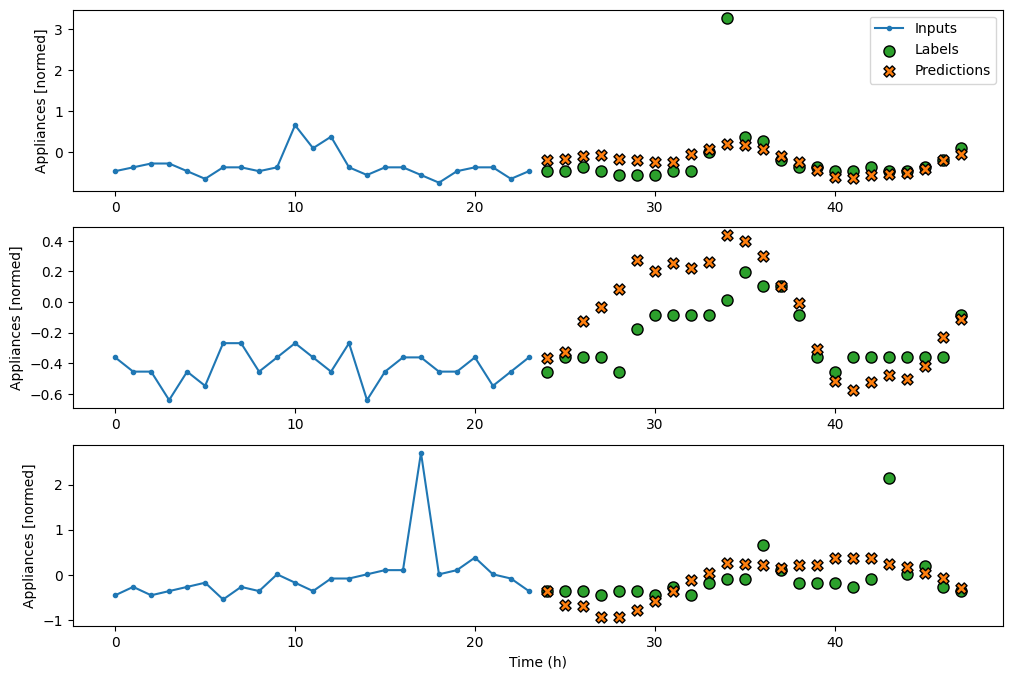

In [41]:
predict_window.plot(cnn_model)

CNN + LSTM

In [54]:
cnn_lstm_model = Sequential([
    Conv1D(256, activation = 'relu', kernel_size = CONV_WIDTH),
    LSTM(32, return_sequences = True),
    LSTM(32, return_sequences = False),
    Dense(OUT_STEPS, kernel_initializer = tf.initializers.zeros),
    Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(cnn_lstm_model, predict_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(predict_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(predict_window.test, verbose = 0)

Epoch 1/50
71/71 [==============================] - 6s 34ms/step - loss: 0.9340 - mean_absolute_error: 0.5530 - val_loss: 0.5992 - val_mean_absolute_error: 0.4333
Epoch 2/50
71/71 [==============================] - 2s 33ms/step - loss: 0.8501 - mean_absolute_error: 0.5114 - val_loss: 0.6145 - val_mean_absolute_error: 0.3964
Epoch 3/50
71/71 [==============================] - 2s 25ms/step - loss: 0.7980 - mean_absolute_error: 0.4968 - val_loss: 0.6549 - val_mean_absolute_error: 0.3688
Epoch 4/50
14/14 [==============================] - 0s 7ms/step - loss: 0.6579 - mean_absolute_error: 0.3860


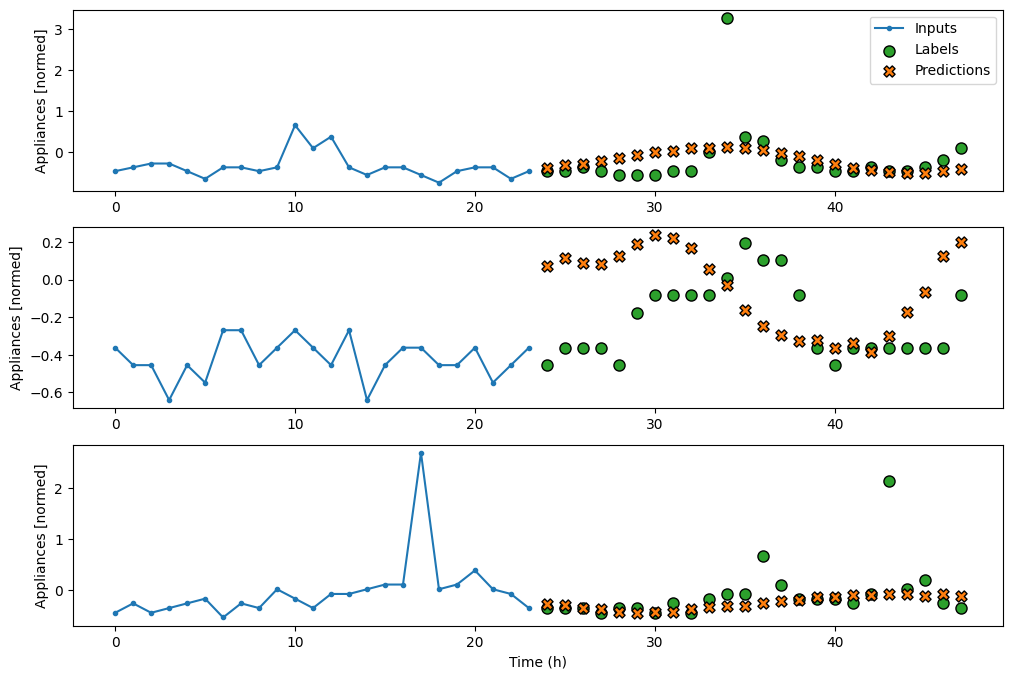

In [55]:
predict_window.plot(cnn_lstm_model)

Evaluating all models

In [56]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

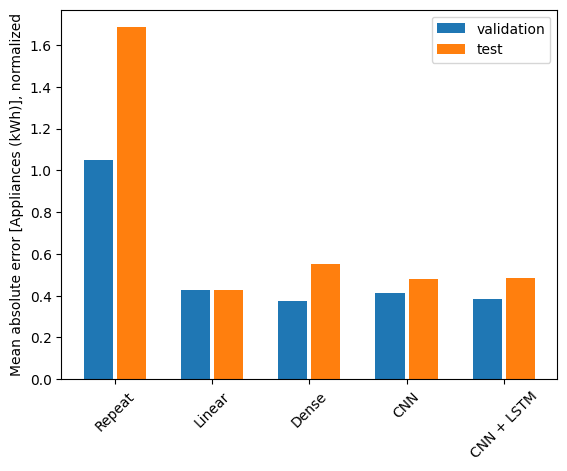

In [59]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = cnn_lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('Mean absolute error [Appliances (kWh)], normalized')
plt.bar(x - 0.17, val_mae, width, label = 'validation')
plt.bar(x + 0.17, test_mae, width, label = 'test')
plt.xticks(ticks=x, labels = performance.keys(), rotation=45)
plt.legend(loc='best')
plt.show()

In [71]:
for name, value in performance.items():
  print(f'{name:} : {value[1]:0.4f}')

Repeat : 1.6847
Linear : 0.4279
Dense : 0.5524
CNN : 0.4816
CNN + LSTM : 0.4835


Linear is best model, predicting next 24 hours

1/1 [==============================] - 0s 22ms/step


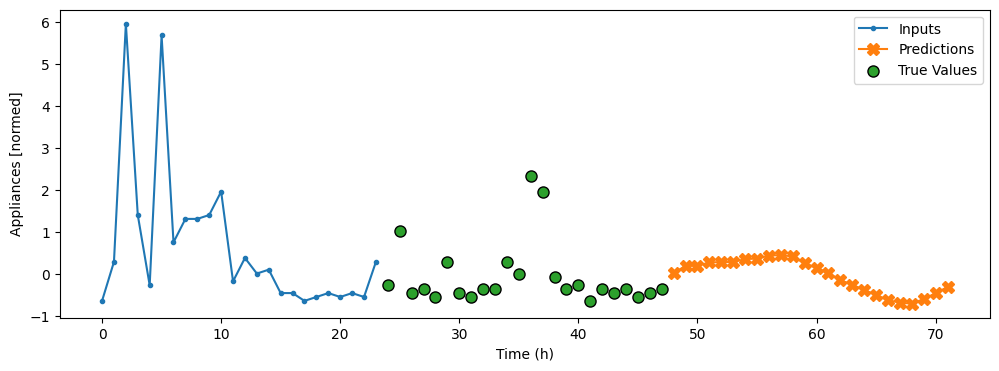

In [109]:
predict_window.plot_predicted_24_hours(linear_model, 'Appliances')